In [1]:
import numpy as np
from scipy.linalg import expm #to esponentiate matrix


#qubit: stato=vettore 2D normalizzato

state=np.array([1.0,0.0], dtype=np.complex64) #stato base=\0>
state/=np.linalg.norm(state)

#define pauli matrix
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
#define hamiltonian
def H(ux,uy):
    return ux*sigma_x+uy*sigma_y
    
#define time evolution
def Evolve(state,ux,uy, deltat):
    U=expm(-1j*H(ux,uy)*deltat)
    new_state=U@state
    return new_state/np.linalg.norm(new_state)

#define fidelity (reward function) as the overlap |<psit|psi'>|^2 (to be maximized)
def Fidelity(target_state,state): 
    f= np.abs(np.vdot(target_state, state))**2
    return min(f,1.0)
#parte 2: passo a spazio continuo
from stable_baselines3 import SAC#per training su spazi continui
#define a gymnasium ambient
import gymnasium as gym
from gymnasium import spaces
import tensorflow as tf
import random
from collections import deque

class Qbitenvironment_continuum(gym.Env):

    def __init__(self):
        super().__init__()

    #define possible actions: continuous tuning of fields
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)

     # Stato osservabile: ⟨σx⟩, ⟨σy⟩, ⟨σz⟩
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)

        self.dt = 0.15  # passo temporale
        
        self.sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex128)
        self.sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
        self.sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

        self.psi_target = np.array([0.0, 1.0], dtype=np.complex128)  
        self.max_steps = 50
        self.reset()


        
    def reset(self, seed=None, options=None):
        #self.psi = np.array([1.0, 0.0], dtype=np.complex128)  # |0⟩
        #self.psi = np.array([1.0/np.sqrt(2), 1.0/np.sqrt(2.0)], dtype=np.complex128)  
        psi = np.random.randn(2) + 1j*np.random.randn(2) #random initial state
        psi/=np.linalg.norm(psi)
        self.psi = psi
        obs = self._get_observation()
        self.current_step = 0
        return obs, {}

    def step(self, action):
        ux = np.clip(action[0], -1.0, 1.0)
        uy = np.clip(action[1], -1.0, 1.0)
        self.psi = Evolve(self.psi, ux, uy, self.dt)
        fidelity = Fidelity(self.psi_target, self.psi)
        obs = self._get_observation()
        self.current_step += 1
        #reward = -np.log(1 - fidelity + 1e-6)  # diverge quando fidelity → 1
        #reward=1/(1-fidelity+1e-6)
        reward=fidelity
        truncated=False
        terminated=False
       # print(f"norm_psi: {np.linalg.norm(self.psi):.4f}, reward: {reward:.4f}, psi={self.psi}")
        #print(ux,uy)
        if fidelity > 0.97:
            terminated=True
            
        if (self.current_step >= self.max_steps):
            truncated = True 
        return obs, reward, terminated, truncated, {}
    
    def _get_observation(self):
        sx = np.vdot(self.psi, self.sigma_x @ self.psi).real
        sy = np.vdot(self.psi, self.sigma_y @ self.psi).real
        sz = np.vdot(self.psi, self.sigma_z @ self.psi).real
        return np.array([sx, sy, sz], dtype=np.float32)

from stable_baselines3.common.callbacks import BaseCallback

class HistoryCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.history = {"actor_loss": [], "critic_loss": [], "entropy_loss": []}

    def _on_step(self) -> bool:
        # Prendi i valori dal logger di SB3
        actor_loss = self.logger.name_to_value.get("train/actor_loss")
        critic_loss = self.logger.name_to_value.get("train/critic_loss")
        entropy_loss = self.logger.name_to_value.get("train/entropy_loss")

        if actor_loss is not None:
            self.history["actor_loss"].append(actor_loss)
        if critic_loss is not None:
            self.history["critic_loss"].append(critic_loss)
        if entropy_loss is not None:
            self.history["entropy_loss"].append(entropy_loss)

        return True

import tensorflow as tf
#sac by hand
env = Qbitenvironment_continuum()
obs_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]
#define Q(s,a) networks
def build_Q(obs_shape, actions_shape):
     input_obs= tf.keras.layers.Input(shape=(obs_shape,))
     input_actions= tf.keras.layers.Input(shape=(actions_shape,))
     input=tf.keras.layers.Concatenate()([input_obs, input_actions])
     h1=tf.keras.layers.Dense(256, activation='relu')(input)
     h2=tf.keras.layers.Dense(256, activation='relu')(h1)
     Q=tf.keras.layers.Dense(1, activation='linear')(h2)
     model=tf.keras.Model(inputs=[input_obs, input_actions], outputs=Q)
     return model

#define policy network
def build_policy(obs_shape, actions_shape):
     inputs= tf.keras.layers.Input(shape=(obs_shape,))
     h1= tf.keras.layers.Dense(256, activation='relu')(inputs)
     h2=tf.keras.layers.Dense(256, activation='relu')(h1)
     mu=tf.keras.layers.Dense(actions_shape, activation='linear')(h2)#first output layer
     logsigma=tf.keras.layers.Dense(actions_shape, activation='linear')(h2)#second output layer
     model=tf.keras.Model(inputs=inputs, outputs=[mu,logsigma])
     return model

def sample_from_policy(mu, log_sigma):
    sigma = tf.exp(log_sigma)
    eps = tf.random.normal(shape=tf.shape(mu))
    a_prime = mu + sigma * eps
    a = tf.tanh(a_prime)
    #logπ(a)=logN(a′∣μ,σ2)−i∑​log(1−tanh2(ai′​)) (change of variables)
    # log N(a'|mu, sigma^2)
    log_prob_gauss = -0.5 * (
        tf.square((a_prime - mu) / (sigma + 1e-8)) +
        2.0 * log_sigma +
        tf.math.log(2.0 * np.pi)
    )
    log_prob_gauss = tf.reduce_sum(log_prob_gauss, axis=-1, keepdims=True)

    # correzione per tanh
    log_det_jac = tf.reduce_sum(
        tf.math.log(1.0 - tf.square(tf.tanh(a_prime)) + 1e-6),
        axis=-1, keepdims=True
    )

    log_pi = log_prob_gauss - log_det_jac
    return a, log_pi

#declaration of optimizers outside the function that calls them, otherwise they will reset their state whenever an opt step is called
optimizer_q1 = tf.keras.optimizers.Adam(learning_rate=3e-4)
optimizer_q2 = tf.keras.optimizers.Adam(learning_rate=3e-4)
optimizer_pi = tf.keras.optimizers.Adam(learning_rate=3e-4)
optimizer_alpha= tf.keras.optimizers.Adam(learning_rate=3e-4)
log_alpha = tf.Variable(0.0, trainable=True, dtype=tf.float32)#to guarantee alpha>=0
alpha = tf.exp(log_alpha)


def Train_Qs(Q1, Q2,state_mb, action_mb, targets):
    with tf.GradientTape(persistent=True) as tape:
     #calculate predictions
        predicted_q1s = Q1([state_mb, action_mb], training=True)
        predicted_q2s = Q2([state_mb, action_mb], training=True)
      #evaluate mse
        mse1= tf.reduce_mean(tf.square(predicted_q1s-targets))
        mse2= tf.reduce_mean(tf.square(predicted_q2s-targets))

      #evaluate gradients
    grad1= tape.gradient(mse1, Q1.trainable_variables)
    grad2= tape.gradient(mse2, Q2.trainable_variables)
      #perform one optimization step using adam
    optimizer_q1.apply_gradients(zip(grad1, Q1.trainable_variables))#apply_gradients want a[gradient, weights]->zip
    optimizer_q2.apply_gradients(zip(grad2, Q2.trainable_variables))
    del tape
    return mse1, mse2




def Train_policy(state_mb, Q1, Q2, policy, log_alpha):

    with tf.GradientTape() as tape:
        mu, logsigma = policy(state_mb, training=True)
        #evaluate action and logpi
        action, log_pi = sample_from_policy(mu, logsigma)
        #update temperature
        entropy = Update_alpha( log_alpha, log_pi)
        #evaluate best estimation of q for the sampled action
        q1=Q1([state_mb, action], training=False)
        q2=Q2([state_mb, action], training=False)
        q=tf.minimum(q1,q2)
        #evaluate loss
        loss=-(tf.reduce_mean(q-tf.exp(log_alpha)*log_pi))#negative loss, i want to maximize -loss
        #evaluate gradient
    grad=tape.gradient(loss, policy.trainable_variables)
        #perform optimization step
    optimizer_pi.apply_gradients(zip(grad, policy.trainable_variables))
    return loss, entropy
    
    
def update_target_network(Q, target_Q, rho=0.995):
    #rho is a parameter that handles the "velocity" of updating the target Qs with the main Qs parameters. 
    #e.g. rho=0-> copy all the parameters of Q into the target network. 
    #by doing so, the target network weights become a mobile average of main network's (stabilize bootstrap of Qs during training)
    main_weights=Q.get_weights()
    target_weights=target_Q.get_weights()
    updated_target_weights= [rho * tw + (1 - rho) * mw for mw, tw in zip(main_weights, target_weights)]
    target_Q.set_weights(updated_target_weights)


def Update_alpha(log_alpha, logpi, Htarget=-2): #from the paper: Htarget=-dim(action space)

    with tf.GradientTape() as tape:
        alpha=tf.exp(log_alpha)
        loss=-tf.reduce_mean(alpha*(logpi+Htarget))
    grad =tape.gradient(loss, [log_alpha])
    optimizer_alpha.apply_gradients(zip(grad, [log_alpha]))
    return loss












In [2]:
import random
import os

#training loop
#define two Q functions
Q1=build_Q(obs_shape, actions_shape)
Q2=build_Q(obs_shape, actions_shape)
#define target copies
target_Q1=build_Q(obs_shape, actions_shape)
target_Q2=build_Q(obs_shape, actions_shape)
target_Q1.set_weights(Q1.get_weights())
target_Q2.set_weights(Q2.get_weights())
#define policy
policy=build_policy(obs_shape, actions_shape)
#initialize replay buffer
replay_buffer = deque(maxlen=200000)
critic_losses1=[]
critic_losses2=[]
actor_losses=[]
entropy_losses=[]
reward_history=[]
#training loop
episodes = 1000
update_target_every = 1
batch_size = 128
gamma = 0.99


for episode in range(episodes):
    state, info= env.reset()
    terminated= False
    truncated = False
    episode_reward=0.0
    steps=0
    while not (terminated or truncated):
        mu, logsigma=policy(state[np.newaxis], training=False)
        action, _=sample_from_policy(mu,logsigma)
        next_state, reward, terminated, truncated, _=env.step(action.numpy()[0])
        done = terminated or truncated
        replay_buffer.append((state, action, reward, next_state, done) )
        state=next_state
        episode_reward+=reward
        steps+=1
        #training
        if(len(replay_buffer)>=batch_size):
            #random sample a batch of transitions from replay buffer
            minibatch= random.sample(replay_buffer, batch_size)
            #targets yi:
            state_mb, action_mb, reward_mb, next_state_mb, done_mb=map(np.array, zip(*minibatch))
            reward_mb = tf.reshape(tf.convert_to_tensor(reward_mb, dtype=tf.float32), (-1,1))
            done_mb   = tf.reshape(tf.convert_to_tensor(done_mb, dtype=tf.float32), (-1,1))
            state_mb  = tf.convert_to_tensor(state_mb, dtype=tf.float32)
            action_mb = tf.convert_to_tensor(action_mb, dtype=tf.float32)
            action_mb = tf.squeeze(action_mb, axis=1)  # (64,1,2) → (64,2)

            next_state_mb = tf.convert_to_tensor(next_state_mb, dtype=tf.float32)

            #evaluate target Qs predictions and take the min
            mutrial, logsigmatrial = policy(next_state_mb, training= False)
            trial_action, log_pi = sample_from_policy(mutrial, logsigmatrial)
            target_qs1=target_Q1([next_state_mb, trial_action], training= False)
            target_qs2=target_Q2([next_state_mb, trial_action], training=False)
            #evaluate targets
            y=reward_mb+gamma*(1-done_mb)*(tf.minimum(target_qs1, target_qs2)- tf.exp(log_alpha)*log_pi)
            #update Q networks
            mse1, mse2= Train_Qs(Q1, Q2, state_mb, action_mb, y)
            critic_losses1.append(mse1)
            critic_losses2.append(mse2)
            #update policy network (and temperature)
            actor_loss, entropy_loss=Train_policy(state_mb, Q1, Q2, policy, log_alpha)
            actor_losses.append(actor_loss)
            entropy_losses.append(entropy_loss)
            #update target networks
            if(steps)%update_target_every==0:
                update_target_network(Q1, target_Q1)
                update_target_network(Q2, target_Q2)
 

    reward_history.append(episode_reward)
    if episode >= 10:
        print(f"Ep {episode:4d} | R={episode_reward:.3f}| AvgR(10)={np.mean(reward_history[-10:]):.3f}| steps={steps}")
    else:
        print(f"Ep {episode:4d} | R={episode_reward:.3f}")




import os

save_dir = "sac_checkpoints.keras"
os.makedirs(save_dir, exist_ok=True)
# salvataggio modelli
policy.save(os.path.join(save_dir, "policy_15steps_restartrandom.keras"))
Q1.save(os.path.join(save_dir, "Q1_15steps_restartrandom.keras"))
Q2.save(os.path.join(save_dir, "Q2_50steps_restartrandom.keras"))
target_Q1.save(os.path.join(save_dir, "target_Q1_15steps_restartrandom.keras"))
target_Q2.save(os.path.join(save_dir, "target_Q2_15steps_restartrandom.keras"))

# salvataggio log_alpha (variabile standalone)
np.save(os.path.join(save_dir, "log_alpha_15steps_restartrandom.npy"), log_alpha.numpy())





Ep    0 | R=19.220
Ep    1 | R=13.943
Ep    2 | R=16.900
Ep    3 | R=13.276
...Ep  998 | R=37.859| AvgR(10)=39.317| steps=50
Ep  999 | R=43.979| AvgR(10)=39.858| steps=50


Ep 1/200 | TotReward=44.369
[TEST] Ep 1/200 | R=0.000 final reward=0.896| steps=50
Ep 2/200 | TotReward=41.875
[TEST] Ep 2/200 | R=0.000 final reward=0.916| steps=50
Ep 3/200 | TotReward=33.180
[TEST] Ep 3/200 | R=0.000 final reward=0.842| steps=50
Ep 4/200 | TotReward=36.962
[TEST] Ep 4/200 | R=0.000 final reward=0.842| steps=50
Ep 5/200 | TotReward=44.497
[TEST] Ep 5/200 | R=0.000 final reward=0.873| steps=50
Ep 6/200 | TotReward=43.201
[TEST] Ep 6/200 | R=0.000 final reward=0.896| steps=50
Ep 7/200 | TotReward=42.708
[TEST] Ep 7/200 | R=0.000 final reward=0.895| steps=50
Ep 8/200 | TotReward=44.589
[TEST] Ep 8/200 | R=0.000 final reward=0.855| steps=50
Ep 9/200 | TotReward=44.815
[TEST] Ep 9/200 | R=0.000 final reward=0.891| steps=50
Ep 10/200 | TotReward=44.310
[TEST] Ep 10/200 | R=0.000 final reward=0.889| steps=50
Ep 11/200 | TotReward=44.543
[TEST] Ep 11/200 | R=0.000 final reward=0.936| steps=50
Ep 12/200 | TotReward=0.981
[TEST] Ep 12/200 | R=0.000 final reward=0.981| steps=1


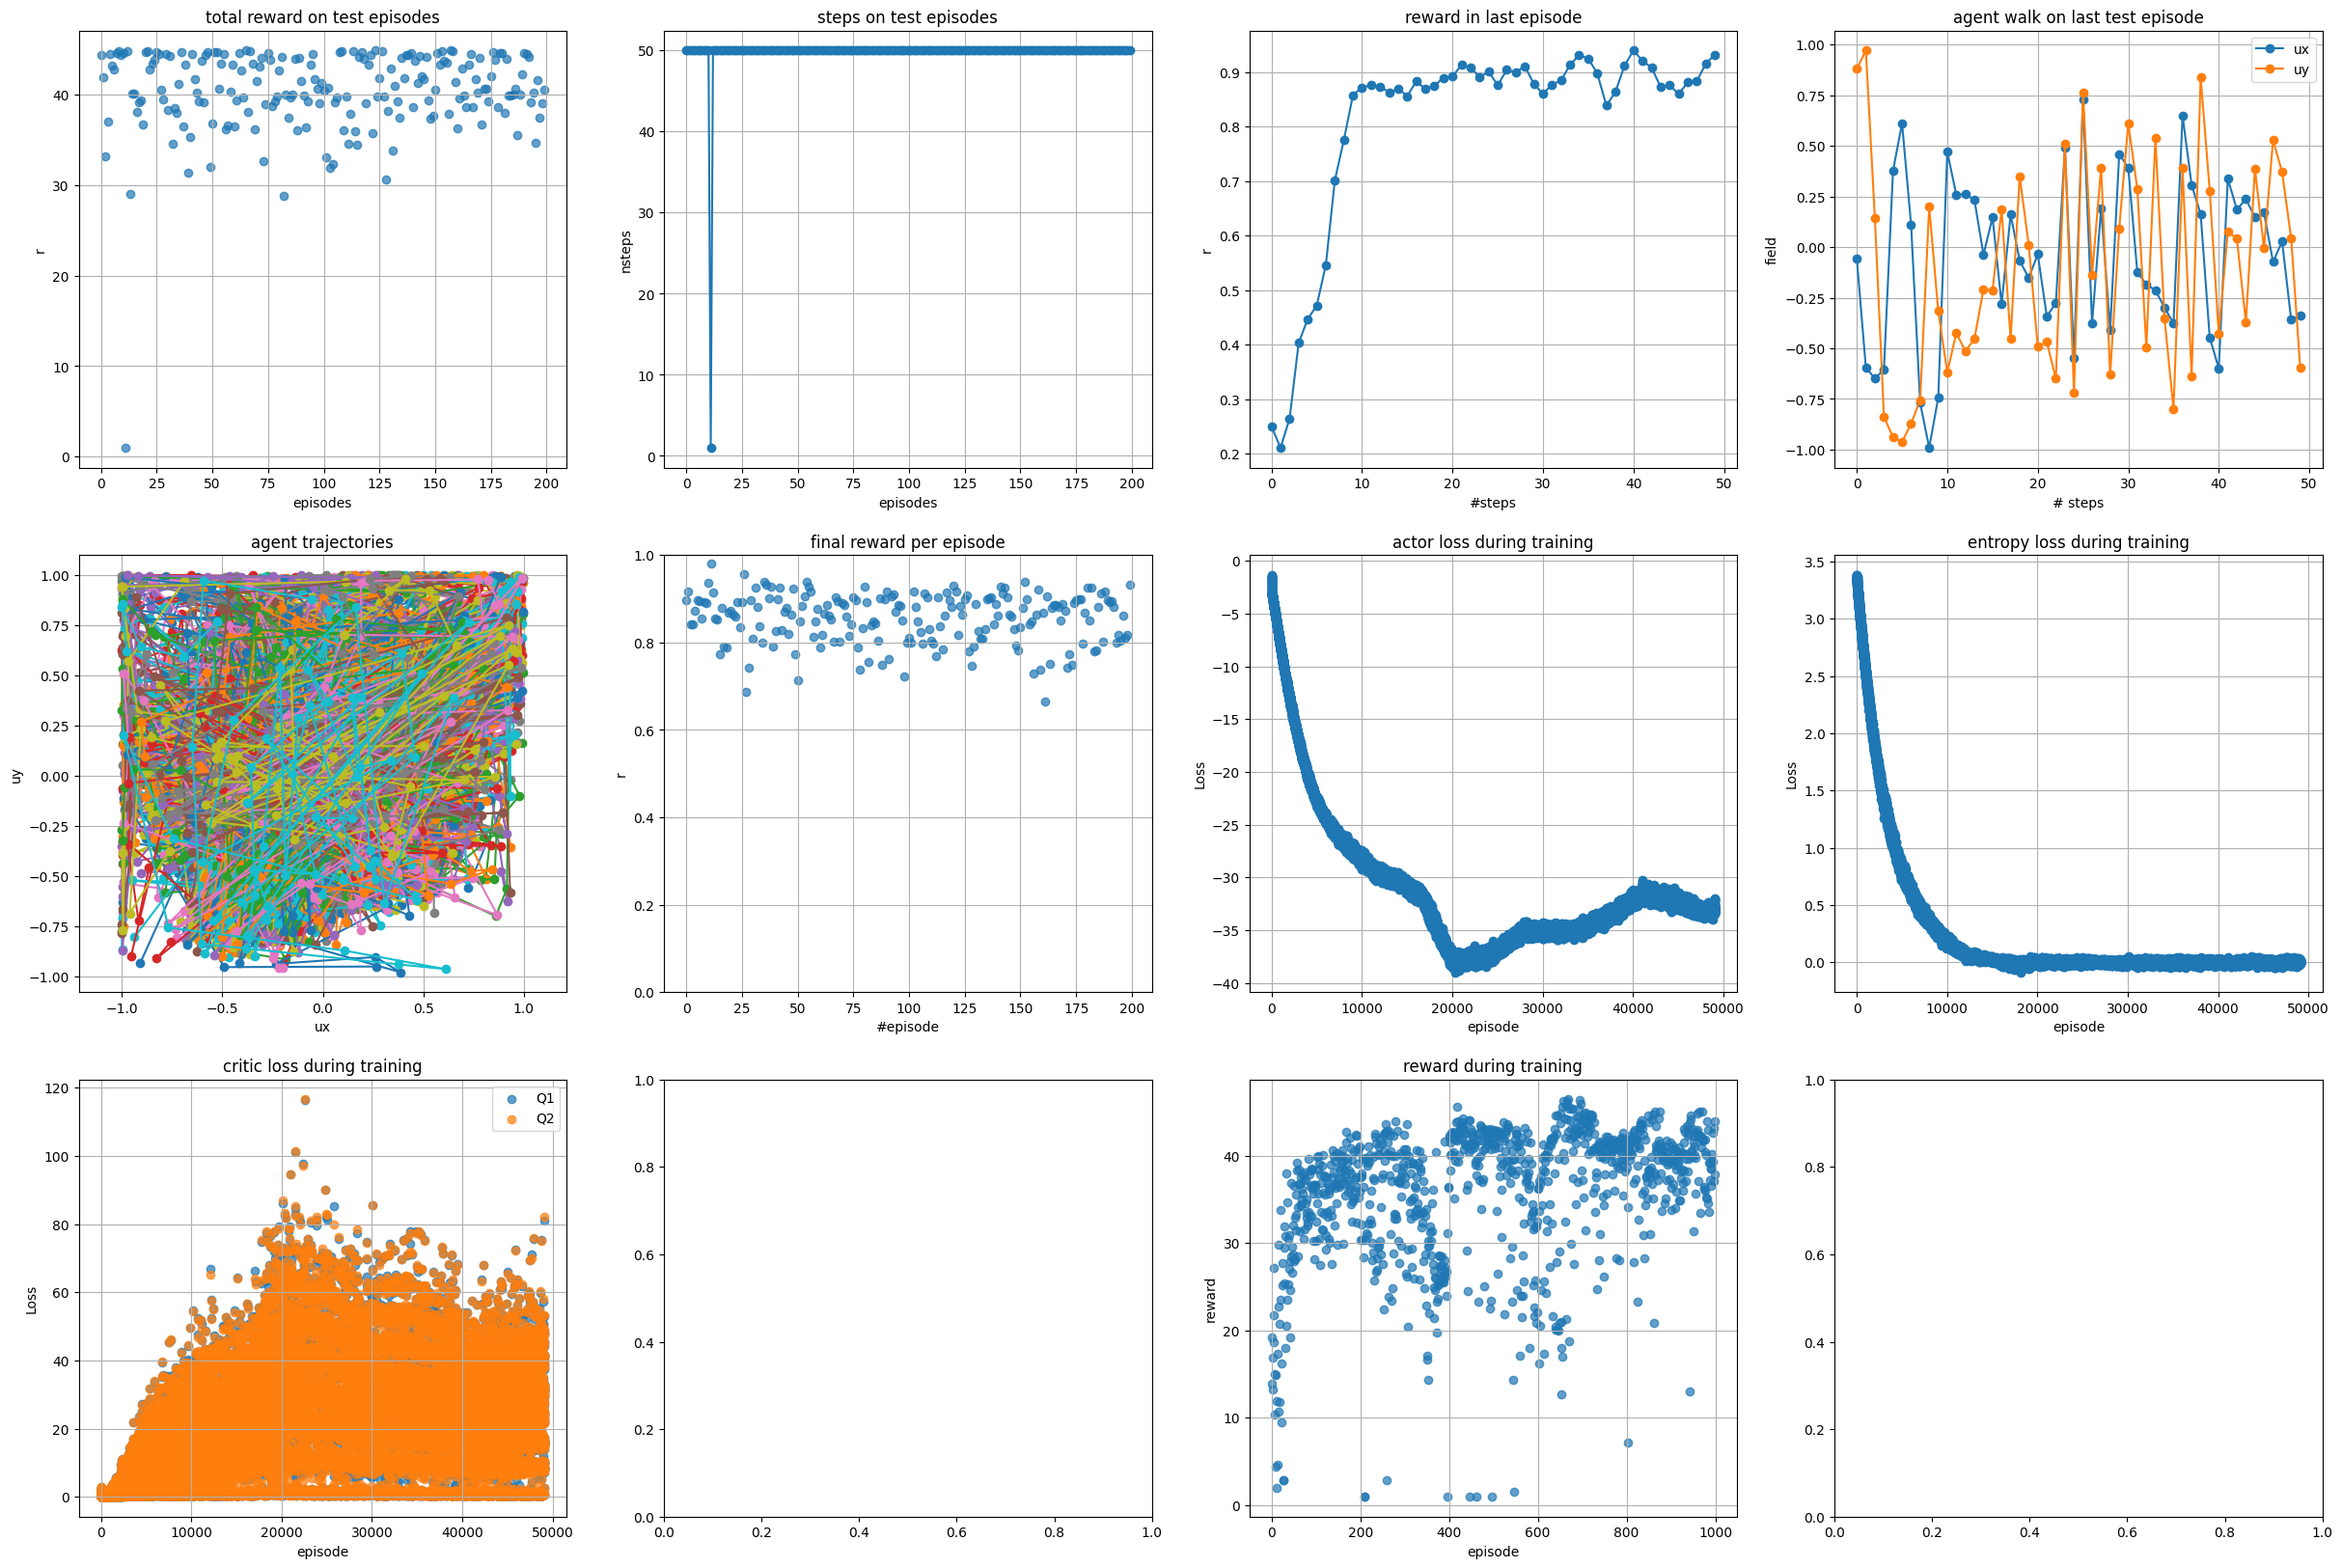

In [60]:
# carica modelli
import os
import matplotlib.pyplot as plt
save_dir = "sac_checkpoints.keras"
os.makedirs(save_dir, exist_ok=True)

policy = tf.keras.models.load_model(os.path.join(save_dir, "policy_15steps_restartrandom.keras"))



def sample_from_policy_eval(mu, log_sigma, eps=1e-6):
    sigma = tf.exp(tf.clip_by_value(log_sigma, -5.0, 2.0))
    epsn  = tf.random.normal(shape=tf.shape(mu))
    a_p   = mu + sigma * epsn
    a     = tf.tanh(a_p)
    return a


total_rewards = []
n_test_episodes = 200

# --- Liste per analisi ---
all_actions_ux = []   # lista di liste: ux scelti in ogni episodio
all_actions_uy = []   # lista di liste: uy scelti in ogni episodio
rewards_per_step = [] # lista di liste: reward a ogni passo per episodio
episode_rewards = []  # reward totale per episodio
test_steps=[]
trajs=[]
episode_final_rewards=[]
for ep in range(n_test_episodes):
    state, info = env.reset()
    done = False
    ep_reward = 0.0
    step = 0
    ep_actions_ux = []
    ep_actions_uy = []
    ep_rewards = []
    ep_traj=[]
    total_reward=0.0

    while not done:
        mu, logsigma = policy(state[np.newaxis], training=False)
        action = sample_from_policy_eval(mu, logsigma).numpy()[0]  # <--- stocastico
        ux=action[0]
        uy=action[1]

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_actions_ux.append(ux)
        ep_actions_uy.append(uy)
        ep_rewards.append(reward)
        total_reward += reward
        step+=1
        state = next_state
        ep_traj.append(env._get_observation())


    all_actions_ux.append(ep_actions_ux)
    all_actions_uy.append(ep_actions_uy)
    rewards_per_step.append(ep_rewards)
    episode_rewards.append(total_reward)
    test_steps.append(step)
    trajs.append(ep_traj)
    episode_final_rewards.append(ep_rewards[-1])

    
    print(f"Ep {ep+1}/{n_test_episodes} | TotReward={total_reward:.3f}")
    total_rewards.append(ep_reward)
    print(f"[TEST] Ep {ep+1}/{n_test_episodes} | R={ep_reward:.3f} final reward={ep_rewards[-1]:.3f}| steps={step}")
avgR = np.mean(total_rewards)
print(f"[TEST] AvgR over {n_test_episodes} episodes = {avgR:.3f}")



# carica i modelli se sei in un’altra sessione
# policy = tf.keras.models.load_model("sac_checkpoints.keras/policy.keras")


def subplots(ax,x,y, title,xlabel,ylabel, label=None):
    ax.plot(x,y, '-o', label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if label is not None:
        ax.legend()
    ax.grid(True)
def scatterplot(ax,x,y, title,xlabel,ylabel, label=None):
    ax.scatter(x,y, label=label, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if label is not None:
        ax.legend()
    ax.grid(True)



fig, ax = plt.subplots(3,4, figsize=(30,20))
ax=ax.flatten()
N=np.arange(n_test_episodes)
scatterplot(ax[0],N, episode_rewards , "total reward on test episodes", "episodes", "r")
subplots(ax[1],N, test_steps, "steps on test episodes", "episodes", "nsteps")
subplots(ax[2], np.arange(test_steps[-1]), rewards_per_step[-1], "reward in last episode", "#steps", "r")
subplots(ax[3],np.arange(test_steps[-1]),ep_actions_ux, "agent walk on last test episode", "# steps", "field", "ux" )
subplots(ax[3],np.arange(test_steps[-1]),ep_actions_uy, "agent walk on last test episode", "# steps", "field", "uy" )

for ep in range(n_test_episodes):

    subplots(ax[4],all_actions_ux[ep],all_actions_uy[ep], "agent trajectories", "ux", "uy" )
ax[4].axis("equal")
scatterplot(ax[5], N, episode_final_rewards, "final reward per episode", "#episode", "r")
ax[5].set_ylim(0,1)
subplots(ax[6], np.arange(len(actor_losses)), actor_losses, "actor loss during training", "episode", "Loss")
subplots(ax[7], np.arange(len(entropy_losses)), entropy_losses, "entropy loss during training", "episode", "Loss")
scatterplot(ax[8], np.arange(len(critic_losses1)), critic_losses1, "critic loss during training", "episode", "Loss", "Q1")
scatterplot(ax[8], np.arange(len(critic_losses2)), critic_losses2, "critic loss during training", "episode", "Loss", "Q2")
scatterplot(ax[10], np.arange(len(reward_history)), reward_history, "reward during training", "episode", "reward")




plt.show()



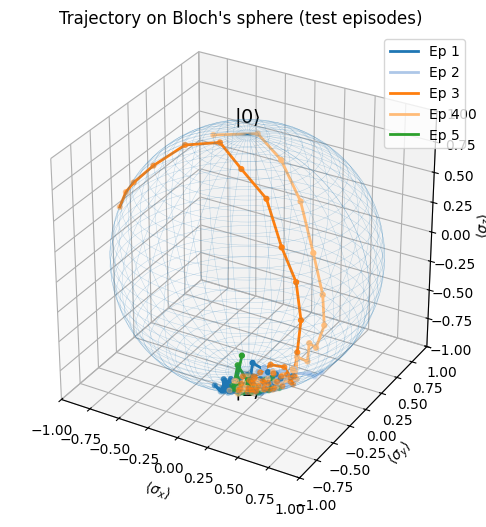

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bloch_from_concatenated(traj, ax, show_points=True, add_labels=False):
    """
    Plotta traiettorie episodiche su ax partendo da un array (nepisodi, nsteps, 3).

    Parameters
    ----------
    traj : array-like, shape (nepisodi, nsteps, 3)
        Sequenza di episodi, ciascuno lungo nsteps punti [sx, sy, sz].
    ax : matplotlib 3D axis
        Asse 3D su cui plottare.
    show_points : bool
        Se True, disegna anche i marker dei punti.
    add_labels : bool
        Se True, aggiunge etichette "Ep k" per la legenda.
    """
    traj = np.asarray(traj)
    if traj.ndim != 3 or traj.shape[2] != 3:
        raise ValueError("traj deve avere shape (nepisodi, nsteps, 3)")

    nepisodi = traj.shape[0]
    cmap = plt.get_cmap("tab20")

    for i in range(nepisodi):
        seg = traj[i]
        sx, sy, sz = seg.T
        color = cmap(i % 20)
        label = f"Ep {i+1}" if add_labels else None
        ax.plot(sx, sy, sz, linewidth=2, color=color, label=label)
        if show_points:
            ax.scatter(sx, sy, sz, s=12, color=color)

# prepara la sfera una volta
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")

u = np.linspace(0, 2*np.pi, 80)
v = np.linspace(0, np.pi, 40)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)

ax.text(0, 0, 1.1, r"$|0\rangle$", fontsize=14, ha='center')
ax.text(0, 0, -1.2, r"$|1\rangle$", fontsize=14, ha='center')
ax.set_xlabel(r'$\langle \sigma_x \rangle$')
ax.set_ylabel(r'$\langle \sigma_y \rangle$')
ax.set_zlabel(r'$\langle \sigma_z \rangle$')
ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
ax.set_box_aspect([1,1,1])
ax.set_title("Trajectory on Bloch's sphere (test episodes)")

# esempio di chiamata

plot_bloch_from_concatenated(trajs[-5:], ax, show_points=True, add_labels=True)

ax.legend()
plt.show()
